In [6]:
import pickle as pkl
with open('data/filtered_annotations.pkl', 'rb') as file:
    annotations = pkl.load(file)

In [1]:
import matplotlib.pyplot as plt

def draw_go_board(b_board, w_board):
    # create a 8" x 8" board
    fig = plt.figure(figsize=[8,8])
    fig.patch.set_facecolor((1,1,.8))
    ax = fig.add_subplot(111)

    # draw the grid
    for x in range(19):
        ax.plot([x, x], [0,18], 'k')
    for y in range(19):
        ax.plot([0, 18], [y,y], 'k')

    # scale the axis area to fill the whole figure
    ax.set_position([0,0,1,1])

    # get rid of axes and everything (the figure background will show through)
    ax.set_axis_off()

    # scale the plot area conveniently (the board is in 0,0..18,18)
    ax.set_xlim(-1,19)
    ax.set_ylim(-1,19)

    # draw Go stones at (10,10) and (13,16)
    def draw_stone(row, col, color):
        if color == 'b':
            ax.plot(row,col,'o',markersize=25, markeredgecolor=(0,0,0), markerfacecolor='k', markeredgewidth=2)
        elif color == 'w':
            ax.plot(row,col,'o',markersize=25, markeredgecolor=(.5,.5,.5), markerfacecolor='w', markeredgewidth=2)

    for i in range(len(b_board)):
        for j in range(len(b_board[0])):
            if b_board[i][j]:
                draw_stone(i, j, 'b')
            if w_board[i][j]:
                draw_stone(i, j, 'w')
    return ax

In [25]:
def draw_feat_map(feat, color, ax):
    for r in range(19):
        for c in range(19):
            if feat[r][c]:
                ax.plot(r, c, 'X', markersize=10, markerfacecolor=color)

### simple eye

In [20]:
def eyes(own, opp):
    feat_map = np.zeros(own.shape)
    for r in range(19):
        for c in range(19):
            if (r == 0 or own[r-1][c]) \
                and (r == 18 or own[r+1][c]) \
                and (c == 0 or own[r][c-1]) \
                and (c == 18 or own[r][c+1]) \
                and (not own[r][c] and not opp[r][c]):
                feat_map[r][c] = 1
    return feat_map
            

### 4-wall

In [27]:
def walls(own, opp, minlen=4):
    feat_map = np.zeros(own.shape)
    for r in range(19):
        cont = 0
        for c in range(19):
            if own[r][c]:
                cont += 1
            else:
                cont = 0
            if cont == minlen:
                for i in range(minlen):
                    feat_map[r][c-i] = 1
            elif cont > minlen:
                feat_map[r][c] = 1
    for c in range(19):
        cont = 0
        for r in range(19):
            if own[r][c]:
                cont += 1
            else:
                cont = 0
            if cont == minlen:
                for i in range(minlen):
                    feat_map[r-i][c] = 1
            elif cont > minlen:
                feat_map[r][c] = 1
    return feat_map

### groups of X connected stones

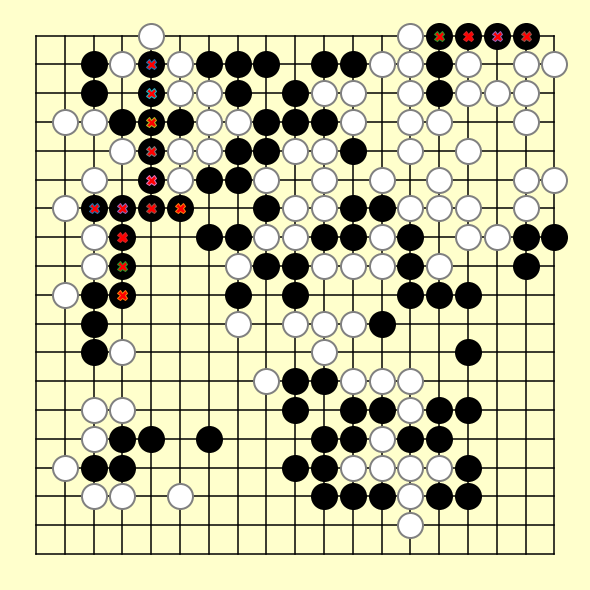

In [29]:
b_board, w_board = annotations[1342]['board_state']
Is = walls(b_board, w_board)
ax = draw_go_board(b_board, w_board)
draw_feat_map(Is, 'r', ax)